In [58]:
%load_ext autoreload
%autoreload 2

import torch

from text3d2video.pipelines.pipeline_utils import load_pipeline

torch.set_grad_enabled(False)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [59]:
from text3d2video.pipelines.texturing_pipeline import TexGenPipeline

pipe: TexGenPipeline = load_pipeline(TexGenPipeline)

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

In [60]:
from text3d2video.artifacts.anim_artifact import AnimationArtifact

anim_tag = "catwalk_180_20:latest"
anim_tag = "mv_penguin:latest"
anim_tag = "mv_backpack:latest"
anim_tag = "mv_human_zoom_head:latest"
anim_tag = "human_mv:latest"
anim_tag = "ymca_zoom_out:latest"
anim_tag = "mv_helmet:latest"
anim_tag = "cat_mv_xatlas:latest"
anim_tag = "mv_cat_statue:latest"
anim_tag = 'lion_zoom_out_src:latest'

texture_anim = AnimationArtifact.from_wandb_artifact_tag(anim_tag)

seq = texture_anim.read_anim_seq()

In [61]:
from text3d2video.utilities.video_comparison import display_vids
from text3d2video.utilities.video_util import pil_frames_to_clip

prompt = "Lion"
uvs = seq.render_rgb_uv_maps()
vid = pil_frames_to_clip(uvs, fps=5)
display_vids([vid], title=prompt)

In [62]:
from pathlib import Path
from text3d2video.mip import seq_max_uv_res
from text3d2video.pipelines.texturing_pipeline import TexGenConfig
from text3d2video.utilities.logging import H5Logger
import torch

texgen_config = TexGenConfig(
    num_inference_steps=10,
    do_text_and_texture_resampling=True,
    use_prev_clean_tex=True,
    use_update_masks=True,
    use_referecnce_kvs=True,
)
    
uv_res = seq_max_uv_res(seq, resolution=512)

generator = torch.Generator(device="cuda")
generator.manual_seed(0)

logger = H5Logger(Path("texgen_data.h5"))
logger.delete_data()
logger.open_write()
logger.enabled = True

out = pipe(
    prompt,
    seq,
    uv_res=uv_res,
    conf=texgen_config,
    generator=generator,
    logger=logger,
)

logger.close()
logger.open_read()

100%|██████████| 10/10 [00:12<00:00,  1.28s/it]


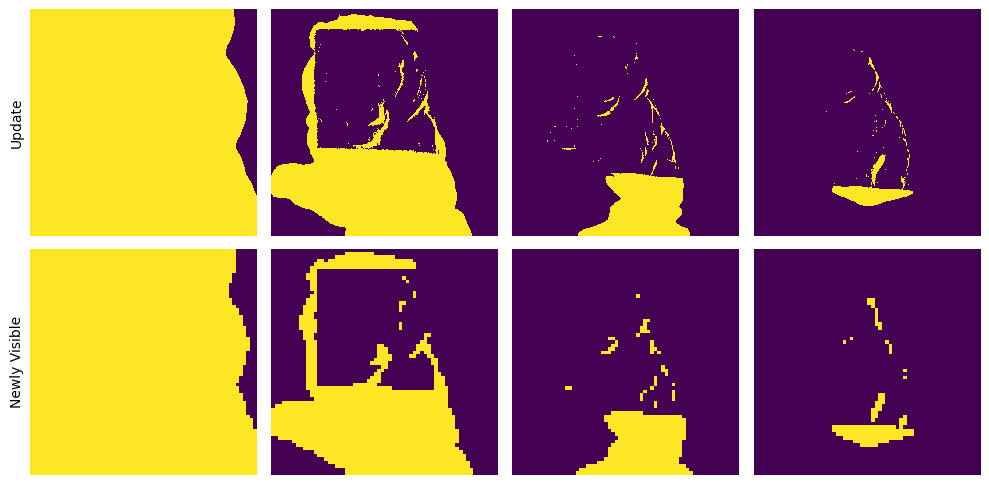

In [63]:
from text3d2video.utilities.ipython_utils import display_ims_grid

update_masks = logger.read("update_masks")
newly_visible = logger.read("newly_visible_masks")

display_ims_grid([update_masks, newly_visible], row_titles=["Update", "Newly Visible"])

In [66]:
images_vid = pil_frames_to_clip(out.images, fps=5)
titles = [prompt]
videos = [images_vid]

display_vids(videos, titles=titles)
# display_ims(images, row_title="ref kvs")

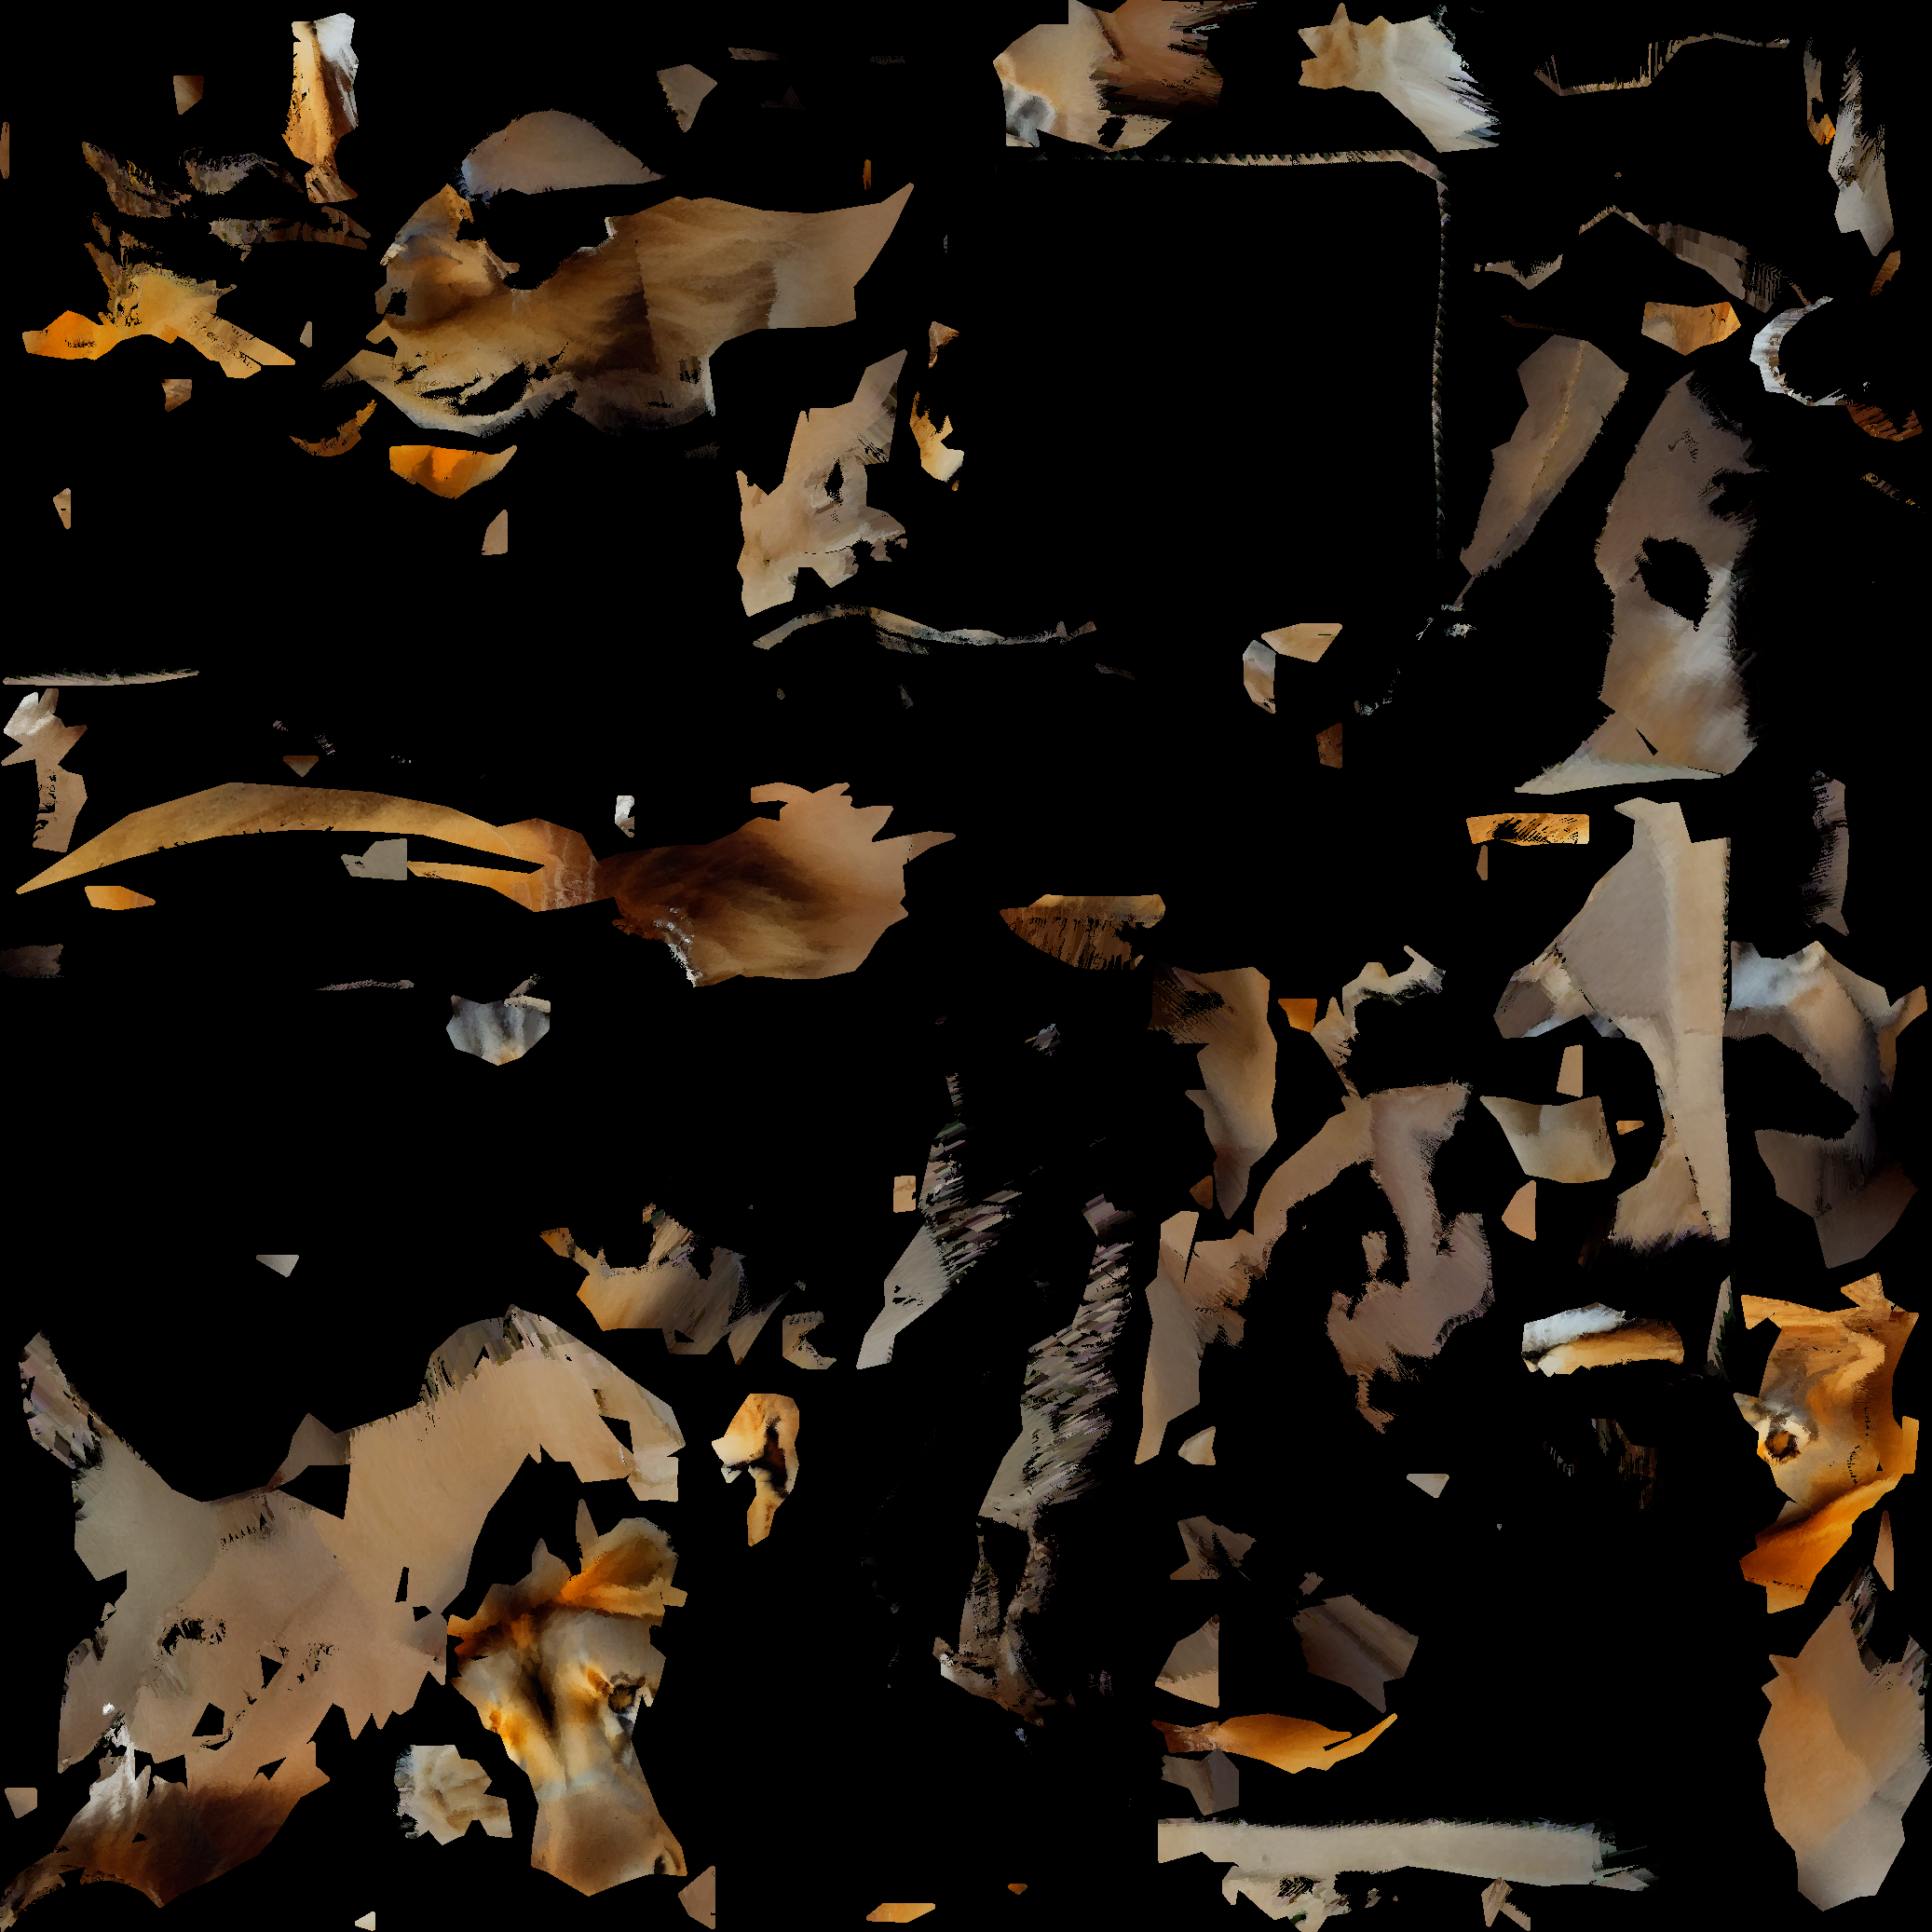

: 

In [ ]:
from text3d2video.rendering import render_texture
from text3d2video.util import hwc_to_chw
from text3d2video.utilities.video_comparison import display_vid
import torchvision.transforms.functional as TF

texture = out.texture

renders = render_texture(
    seq.meshes, seq.cams, texture, seq.verts_uvs, seq.faces_uvs, return_pil=True
)

TF.to_pil_image(hwc_to_chw(texture).cpu())

# display_vid(pil_frames_to_clip(renders, fps=5))